In [363]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

%matplotlib inline

## Importing the database

In [364]:
bnb = pd.read_csv('train.csv', index_col='id')
bnb.shape

(74111, 28)

In [365]:
bnb.head(2)

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0


## Preprocessing and data cleansing

In [366]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 28 columns):
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               58284 non-null object
latitude            

> There are some missing values in the data set

> Some features are not in the right type

In [367]:
bnb.nunique()

log_price                   767
property_type                35
room_type                     3
amenities                 67122
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               73479
first_review               2554
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           80
host_since                 3087
instant_bookable              2
last_review                1371
latitude                  74111
longitude                 74111
name                      73359
neighbourhood               619
number_of_reviews           371
review_scores_rating         54
thumbnail_url             65883
zipcode                     769
bedrooms                     11
beds                         18
dtype: int64

> according to `description` and `name` it seems there are duplicated rows

### Tranforming amenities into columns:

In [368]:
amenities = bnb.amenities.str.split(',')
amenities = list(*zip(*amenities))
len(amenities)

74111

In [369]:
# removing duplicates:

amenities = list(set([am.strip('{').strip('}').strip('{}}') for am in amenities])) # list of unique amenities
amenities.remove('')
print(len(amenities))
amenities

38


['Essentials',
 '"Smoking allowed"',
 '"Self Check-In"',
 '"Stair gates"',
 '"Free parking on premises"',
 '"Host greets you"',
 'Breakfast',
 'Internet',
 '"Laptop friendly workspace"',
 'Elevator',
 'Doorman',
 '"Buzzer/wireless intercom"',
 'Gym',
 '"Single level home"',
 'Shampoo',
 'Kitchen',
 '"Air conditioning"',
 'Heating',
 '"Lock on bedroom door"',
 '"translation missing: en.hosting_amenity_50"',
 'Washer',
 'Pool',
 '"translation missing: en.hosting_amenity_49"',
 '"Wireless Internet"',
 '"First aid kit"',
 'TV',
 'Stove',
 '"Suitable for events"',
 '"Pets allowed"',
 '"Wheelchair accessible"',
 '"Elevator in building"',
 '"Wide entryway"',
 '"Family/kid friendly"',
 '"Fire extinguisher"',
 '"Pets live on this property"',
 '"Cable TV"',
 '"Smoke detector"',
 '"Carbon monoxide detector"']

In [370]:
# removing untranslated values:

for am in amenities:
    if 'missing' in am:
        amenities.remove(am)
        
len(amenities)

36

In [371]:
# assigning new bool columns for amenities:

for am in amenities:
    bnb[am] = bnb.amenities.str.contains(am)

bnb = bnb.drop(columns='amenities')

In [372]:
bnb.head(2)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,...,"""Pets allowed""","""Wheelchair accessible""","""Elevator in building""","""Wide entryway""","""Family/kid friendly""","""Fire extinguisher""","""Pets live on this property""","""Cable TV""","""Smoke detector""","""Carbon monoxide detector"""
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,False,False,False,False,True,False,False,False,False,False
6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,...,False,False,False,False,True,True,False,False,True,False


### Replacing strings to booleans

In [373]:
st_to_bool = {'t':True, 'f':False}
bnb = bnb.replace(to_replace=st_to_bool)

### Replacing strings into dates and numeric

In [374]:
bnb['first_review'] = pd.to_datetime(bnb['first_review'], errors='coerce')
bnb['last_review'] = pd.to_datetime(bnb['last_review'], errors='coerce')

## Dealing with missing values

looking for NaN values in the datafame:

In [375]:
bnb.isna().sum().loc[bnb.isna().sum()>0]

bathrooms                   200
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
last_review               15827
neighbourhood              6872
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

**I'll solve NaN values only for columns that will be in use later in the model**

### bedrooms, beds:

These features have great impact on the price so it's best to drop the rows rather than estimate its value

In [376]:
bnb.loc[:,['log_price','beds','bedrooms','accommodates','bathrooms']].corr()

,log_price,beds,bedrooms,accommodates,bathrooms
log_price,1.000000,0.442153,0.473212,0.567574,0.355420
beds,0.442153,1.000000,0.709416,0.810801,0.525591
bedrooms,0.473212,0.709416,1.000000,0.709258,0.589935
accommodates,0.567574,0.810801,0.709258,1.000000,0.505632
bathrooms,0.355420,0.525591,0.589935,0.505632,1.000000


In [377]:
print(bnb.shape)
bnb = bnb.loc[~(bnb.loc[:,'beds'].isna()) & ~(bnb.loc[:,'bedrooms'].isna()) & ~(bnb.loc[:,'bathrooms'].isna()),:]
bnb.shape

(74111, 63)


(73766, 63)

### neighbourhood

The price may vary between neighbourhoods in a city and we don't want to drop that much data so we'll run a KNN-classification for predicting the neighbourhood name accordding to it's location - `longitude` and `latitude`

In [378]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [379]:
# first I'll drop neighbourhoods with less than 10 listings offered in:

pivot_hood = bnb.pivot_table(index='neighbourhood', columns='city', values='log_price', aggfunc='count')

In [380]:
pivot_hood.columns.tolist()

['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']

In [381]:
pivot_hood.loc[(pivot_hood.Boston<50) | (pivot_hood.Chicago<50) | (pivot_hood.DC<50) | (pivot_hood.NYC<50) | (pivot_hood.SF<50),:].count()

city
Boston      18
Chicago     58
DC          87
LA           7
NYC        135
SF          24
dtype: int64

In [382]:
bnb_fill_hood = bnb.loc[~bnb.neighbourhood.isna()]
bnb_fill_hood.head(1)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,...,"""Pets allowed""","""Wheelchair accessible""","""Elevator in building""","""Wide entryway""","""Family/kid friendly""","""Fire extinguisher""","""Pets live on this property""","""Cable TV""","""Smoke detector""","""Carbon monoxide detector"""
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,False,False,False,False,True,False,False,False,False,False


In [383]:
X = bnb_fill_hood.loc[:,['latitude','longitude']]
y = bnb_fill_hood.loc[:,'neighbourhood']
X.shape, y.shape

((66919, 2), (66919,))

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [385]:
knn_hood = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [386]:
y_train_pred = knn_hood.predict(X_train)
y_test_pred = knn_hood.predict(X_test)

In [387]:
print(f'train score: {accuracy_score(y_train_pred,y_train)}')
print(f'test score: {accuracy_score(y_test_pred,y_test)}')

train score: 0.9738675632763613
test score: 0.9580095636580992


In [388]:
y_test_pred.shape, y_test.shape

((13384,), (13384,))

**There were 619 different neighbourhoods to choose from - excellent scores for train and validation test**

In [389]:
fill_hood_index = bnb.index[bnb.neighbourhood.isna()==True]

In [390]:
# matching the neighbourhood prediction for missing values: 

bnb.loc[fill_hood_index,'neighbourhood'] = knn_hood.predict(bnb.loc[bnb.neighbourhood.isna()].loc[:,['latitude','longitude']])

In [391]:
# checking that there are no more NaN:

bnb.neighbourhood.isna().sum()

0

### other features

In [392]:
# hosts without response rate meaning he\she never had a chat with potential guests
# and therefore I'll assign zero as response time:
bnb.host_response_rate.fillna(value=0,inplace=True)

# hosts who don't have a value for profile pic or verified identity will get a False value: 
bnb.host_has_profile_pic.fillna(value=False,inplace=True)
bnb.host_identity_verified.fillna(value=False,inplace=True)

# review score is an important value so instead of assigning zero, I'll use the median value:
bnb.review_scores_rating.fillna(value=bnb.review_scores_rating.median(),inplace=True)


In [393]:
# transforming the host_response_rate feature to float
bnb['host_response_rate'] = bnb['host_response_rate'].apply(lambda rate: float(str(rate).strip('%'))/100)

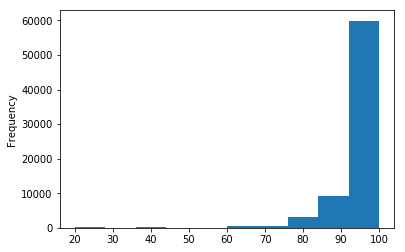

In [394]:
bnb.review_scores_rating.plot(kind='hist')
plt.show()

In [395]:
bnb.isna().sum().loc[bnb.isna().sum()>0]

first_review     15782
host_since         187
last_review      15745
thumbnail_url     8155
zipcode            951
dtype: int64

### Feature engineering

**I'll remove `property_type` with less than 50 observations**

In [396]:
type_df = bnb.property_type.value_counts()
property_type_del = type_df.loc[type_df<50].index

property_type_del

Index(['Serviced apartment', 'Tent', 'Castle', 'Vacation home', 'Yurt', 'Hut',
       'Treehouse', 'Chalet', 'Earth House', 'Tipi', 'Train', 'Cave',
       'Casa particular', 'Island', 'Lighthouse'],
      dtype='object')

In [397]:
print(bnb.shape)
bnb = bnb.loc[~bnb.property_type.isin(property_type_del),:]
bnb.shape

(73766, 63)


(73659, 63)

### Duplicated rows

In [398]:
dup_description = bnb.description.value_counts().to_frame().reset_index().rename(columns={'index':'description','description':'count'})
dup_description.head()

,description,count
0,"Hello, I've been running guest house for Korea...",8
1,Private room in the heart of Little Italy with...,7
2,"Welcome to RMH, a co-ed hostel vibe home for e...",6
3,OutpostClub is a network of Coliving locations...,5
4,At the intersection of the charming Leather Di...,5


> It's possible that there are duplicated rows in the data set - it's unlikely that two different lists have the exact description.


In [399]:
print(bnb.shape)
bnb.drop_duplicates(subset=['log_price','property_type','room_type','accommodates','bathrooms','bed_type','latitude','longitude','cleaning_fee','city','description']
                    ,inplace=True)
bnb.shape

(73659, 63)


(73659, 63)

> I didn't find duplicated rows - let's look dipper at the location of listings with the same description

In [400]:
bnb.loc[bnb.description == dup_description.iloc[0].description,['longitude','latitude']]

,longitude,latitude
id,,
19802577,-118.276606,34.053100
1210748,-118.278478,34.051996
114203,-118.276467,34.053377
10925833,-118.277101,34.052114
9129016,-118.278387,34.051446
7873771,-118.277737,34.053357
15344934,-118.278568,34.051674
17624124,-118.276372,34.053081


> There are minor changes in the `longitude` and `latitude` but the listings are the same so I'll drop them

In [401]:
print(bnb.shape)
bnb = bnb.drop_duplicates(subset=['log_price','property_type','room_type','accommodates','bathrooms','bed_type','cleaning_fee','city','description'])
bnb.shape

(73659, 63)


(73433, 63)

In [402]:
bnb.describe([0.01,0.25,0.5,0.75,0.99])

,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,73433.000000,73433.00000,73433.000000,73433.000000,73433.000000,73433.000000,73433.000000,73433.000000,73433.000000,73433.000000
mean,4.783953,3.15952,1.235017,0.709905,38.450870,-92.366768,20.875819,94.515313,1.267060,1.711955
std,0.716905,2.15362,0.581009,0.431248,3.078510,21.698254,37.785252,6.929446,0.853638,1.253730
min,0.000000,1.00000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
1%,3.367296,1.00000,1.000000,0.000000,33.790416,-122.464538,0.000000,66.000000,0.000000,1.000000
25%,4.317488,2.00000,1.000000,0.000000,34.129138,-118.342387,1.000000,93.000000,1.000000,1.000000
50%,4.718499,2.00000,1.000000,1.000000,40.662565,-76.996324,6.000000,96.000000,1.000000,1.000000
75%,5.220356,4.00000,1.000000,1.000000,40.746301,-73.954634,23.000000,99.000000,1.000000,2.000000
99%,6.897382,12.00000,3.500000,1.000000,42.358506,-71.058922,178.000000,100.000000,4.000000,6.000000
max,7.600402,16.00000,8.000000,1.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


> It seems there are no outliers but there are some missing values

In [403]:
bnb['price'] = np.exp(bnb.log_price)

In [404]:
bnb.head(2)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,...,"""Wheelchair accessible""","""Elevator in building""","""Wide entryway""","""Family/kid friendly""","""Fire extinguisher""","""Pets live on this property""","""Cable TV""","""Smoke detector""","""Carbon monoxide detector""",price
id,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,False,False,False,True,False,False,False,False,False,150.0
6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,...,False,False,False,True,True,False,False,True,False,169.0


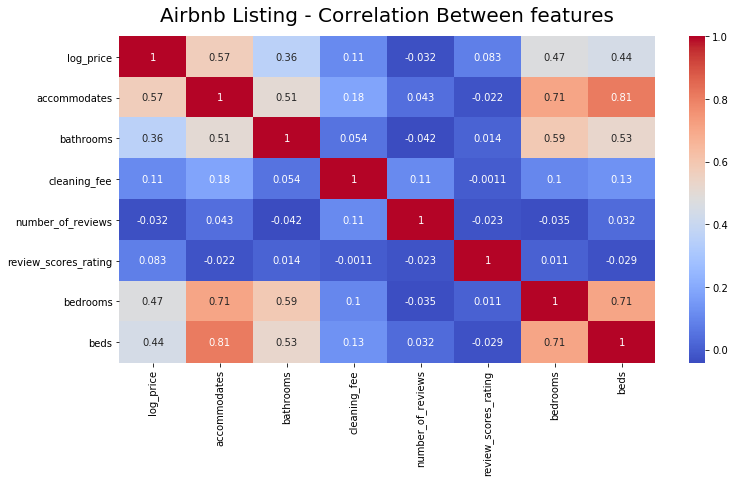

In [405]:
bnb_corr = bnb.loc[:,['log_price','accommodates','bathrooms','cleaning_fee','number_of_reviews','review_scores_rating','bedrooms','beds']].corr()

plt.figure(figsize=(12,6))
sns.heatmap(bnb_corr, cmap='coolwarm',annot=True)
plt.title('Airbnb Listing - Correlation Between features',fontdict={'fontsize':20}, pad=15)
plt.show()

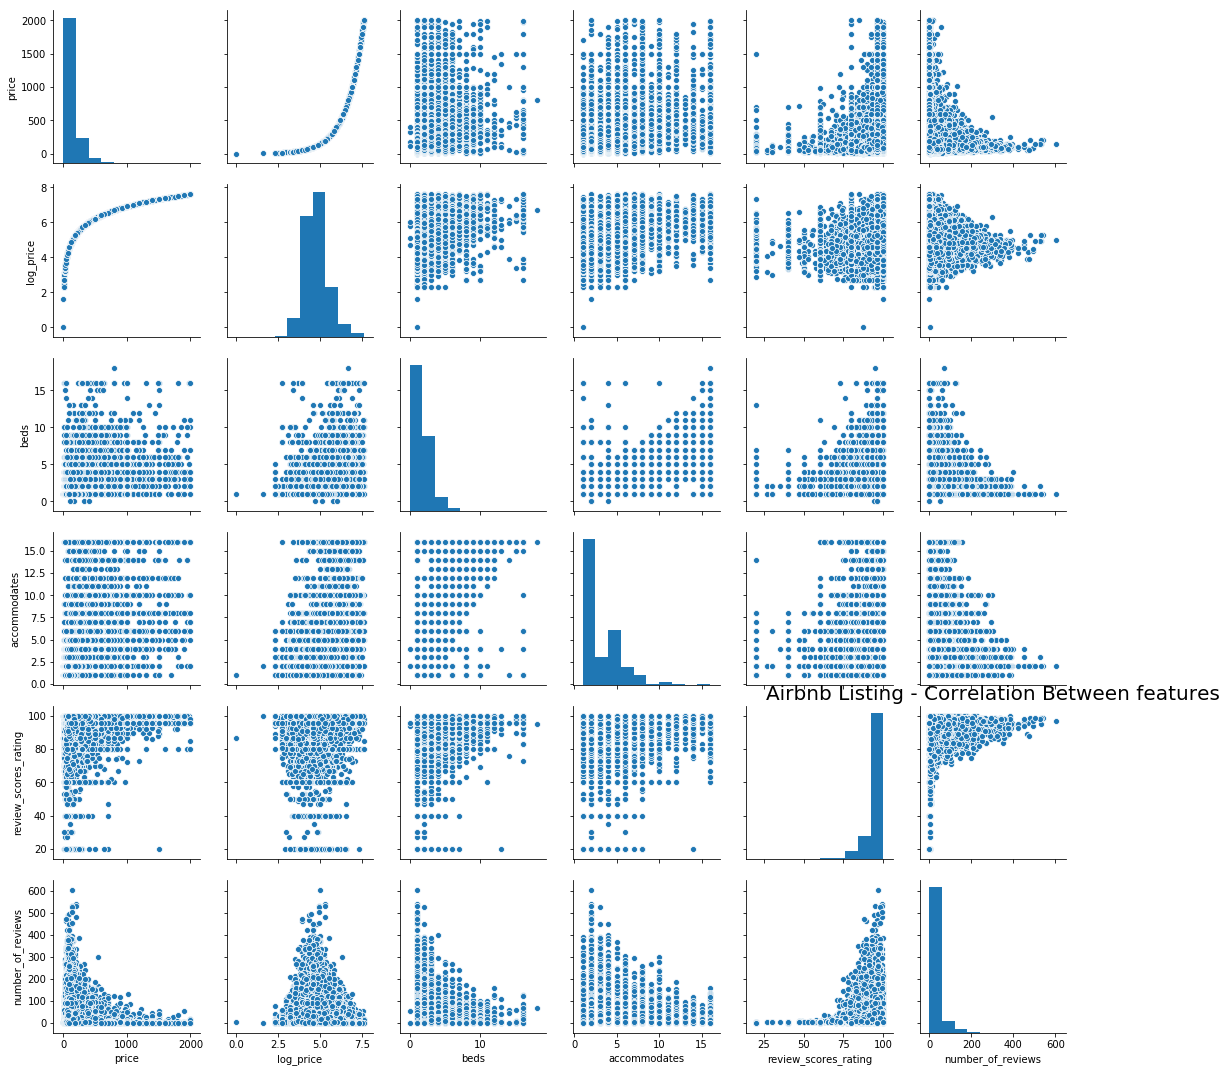

In [406]:
sns.pairplot(data=bnb.loc[:,['price','log_price','beds','accommodates','review_scores_rating','number_of_reviews']])
plt.title('Airbnb Listing - Correlation Between features',fontdict={'fontsize':20})
plt.show()

> `log_price` is more sutable for regression analysis than regular `price` 

## Modeling

dealing with non-numeric values:

In [407]:
# removing irrelevant columns for the model:

bnb_model = bnb.drop(columns=['price','description','first_review','host_since','last_review',
                              'latitude', 'longitude', 'name','thumbnail_url', 'zipcode'])


# assigning dummies for categorical features:

bnb_model = pd.get_dummies(bnb_model, drop_first=True)

In [408]:
bnb_model.shape

(73433, 699)

In [409]:
X = bnb_model.drop(columns='log_price')
y = bnb_model.log_price

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

### Linear Regression

In [411]:
bnb_lm = LinearRegression().fit(X_train, y_train)

In [412]:
y_train_pred = bnb_lm.predict(X_train)
y_test_pred = bnb_lm.predict(X_test)

In [413]:
rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(y_test_pred, y_test))

In [414]:
print(f'rmse of train set: {rmse_train}')
print(f'rmse of test set: {rmse_test}')

rmse of train set: 0.4048810535835567
rmse of test set: 0.4112444615899534


> The model is not overfitted

> I'll try to get better results using grid search

Applying GridSearch for better hyper paramters tuning:

In [415]:
steps = [('scaler', MinMaxScaler()), 
         ('model', Ridge())]

pipe = Pipeline(steps)

params = {'scaler': [MinMaxScaler(), MaxAbsScaler(), StandardScaler()], 
         'model': [Lasso(), Ridge()], # alpha=0 for LinearRegression
         'model__alpha': range(0,5)}

gs = GridSearchCV(pipe, param_grid=params, cv=10, return_train_score=False,
                  scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'scaler': [MinMaxScaler(copy=True, feature_range=(0, 1)), MaxAbsScaler(copy=True), StandardScaler(copy=True, with_mean=True, with_std=True)], 'model': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None...one,
   normalize=False, random_state=None, solver='auto', tol=0.001)], 'model__alpha': range(0, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [416]:
gs.best_params_

{'model': Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'model__alpha': 3,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [417]:
gs.best_score_

-0.1684507951120057

In [418]:
gs.best_score_

-0.1684507951120057

In [419]:
lr_model = gs.best_estimator_

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(f'rmse of train set: {rmse_train}')
print(f'rmse of test set: {rmse_test}')

rmse of train set: 0.4054416808701725
rmse of test set: 0.41039127642815987


> The results indeed improved!

#### Exploring GS results:

In [420]:
grid_results = pd.DataFrame(gs.cv_results_)
df_scores = grid_results.sort_values(by='mean_test_score',ascending=False)[['params', 'mean_test_score', 'std_test_score' ]].head(10)
df_scores[['mean_test_score', 'std_test_score']] = np.sqrt(df_scores[['mean_test_score', 'std_test_score']].abs())
df_scores.head()

,params,mean_test_score,std_test_score
24,"{'model': Ridge(alpha=3, copy_X=True, fit_inte...",0.410428,0.083736
25,"{'model': Ridge(alpha=3, copy_X=True, fit_inte...",0.410428,0.083740
27,"{'model': Ridge(alpha=3, copy_X=True, fit_inte...",0.410453,0.083863
28,"{'model': Ridge(alpha=3, copy_X=True, fit_inte...",0.410453,0.083869
21,"{'model': Ridge(alpha=3, copy_X=True, fit_inte...",0.410468,0.083626


In [421]:
grid_mean_std = grid_results.loc[:,['mean_score_time','std_score_time']]

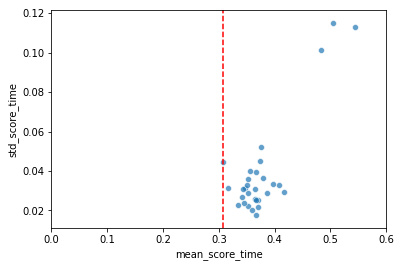

In [422]:
sns.scatterplot(x=grid_mean_std.mean_score_time,y=grid_mean_std.std_score_time,
               alpha=0.7)
plt.xlim(0,0.6)

plt.axvline(x=grid_mean_std['mean_score_time'].min(), c='red', linestyle='dashed',
            label="min_std")

plt.show()

In [423]:
results = {}
results['lr'] = rmse_test.round(2)

### Decision Tree Regression

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [425]:
parameters = {'max_depth':[5,8,12],
              'min_samples_leaf': [5, 10, 15, 20, 25]}

In [426]:
grid_search = GridSearchCV(DecisionTreeRegressor(), parameters, cv=10, return_train_score=False,
                           n_jobs=-1, scoring='neg_mean_squared_error')

In [427]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 8, 12], 'min_samples_leaf': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [428]:
tree_estimator = grid_search.best_estimator_

In [429]:
y_train_pred = tree_estimator.predict(X_train)
y_test_pred = tree_estimator.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_test = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(f'rmse of train set: {rmse_train}')
print(f'rmse of test set: {rmse_test}')

rmse of train set: 0.4281723556634301
rmse of test set: 0.45013722718537075


In [430]:
grid_results = pd.DataFrame(grid_search.cv_results_)
df_scores = grid_results.sort_values(by='rank_test_score')[['params', 'mean_test_score', 'std_test_score' ]].head(10)
df_scores[['mean_test_score', 'std_test_score']] = np.sqrt(df_scores[['mean_test_score', 'std_test_score']].abs())
df_scores.head()

,params,mean_test_score,std_test_score
14,"{'max_depth': 12, 'min_samples_leaf': 25}",0.450784,0.080737
13,"{'max_depth': 12, 'min_samples_leaf': 20}",0.452020,0.079069
12,"{'max_depth': 12, 'min_samples_leaf': 15}",0.452572,0.076499
11,"{'max_depth': 12, 'min_samples_leaf': 10}",0.454445,0.076472
9,"{'max_depth': 8, 'min_samples_leaf': 25}",0.460244,0.082503


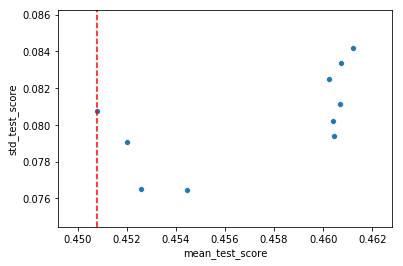

In [431]:
sns.scatterplot(x=df_scores.mean_test_score,y=df_scores.std_test_score)
plt.axvline(x=df_scores['mean_test_score'].min(), c='red', linestyle='dashed',
            label="min_std")

plt.show()

In [432]:
results['dt'] = rmse_test.round(2)

### Random Forest

In [433]:
from sklearn.ensemble import RandomForestRegressor

In [434]:
parameters = {'max_depth':[5,8,10],
              'min_samples_leaf': [5, 10, 15, 20, 25]}

In [435]:
grid_search = GridSearchCV(RandomForestRegressor(n_estimators=100), parameters, cv=10, return_train_score=False,
                           n_jobs=-1, scoring='neg_mean_squared_error')

In [436]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 8, 10], 'min_samples_leaf': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [437]:
rf_estimator = grid_search.best_estimator_

In [438]:
y_train_pred = rf_estimator.predict(X_train)
y_test_pred = rf_estimator.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rf_rmse_test = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(f'rmse of train set: {rmse_train}')
print(f'rmse of test set: {rf_rmse_test}')

rmse of train set: 0.4157810415043975
rmse of test set: 0.4351491978704057


In [439]:
grid_results = pd.DataFrame(grid_search.cv_results_)
rf_df_scores = grid_results.sort_values(by='rank_test_score')[['params', 'mean_test_score', 'std_test_score' ]].head(10)
rf_df_scores[['mean_test_score', 'std_test_score']] = np.sqrt(df_scores[['mean_test_score', 'std_test_score']].abs())
rf_df_scores.head()

,params,mean_test_score,std_test_score
10,"{'max_depth': 10, 'min_samples_leaf': 5}",0.678783,0.288723
11,"{'max_depth': 10, 'min_samples_leaf': 10}",0.674126,0.276535
12,"{'max_depth': 10, 'min_samples_leaf': 15}",0.672735,0.276584
13,"{'max_depth': 10, 'min_samples_leaf': 20}",0.672324,0.281193
14,"{'max_depth': 10, 'min_samples_leaf': 25}",0.671404,0.284142


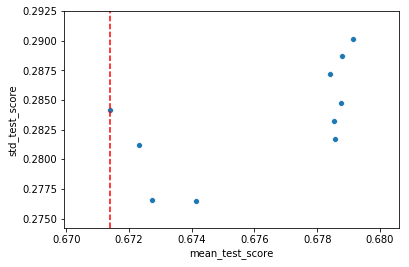

In [440]:
sns.scatterplot(x=rf_df_scores.mean_test_score,y=rf_df_scores.std_test_score)
plt.axvline(x=rf_df_scores['mean_test_score'].min(), c='red', linestyle='dashed',
            label="min_std")

plt.show()

In [441]:
results['rf'] = rf_rmse_test.round(2)

### XGBOOST

In [442]:
import xgboost as xgb

In [443]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [444]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 4, alpha = 10, n_estimators = 200, n_jobs=-1)

In [445]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
          'booster':'gblinear', 'max_depth': 4, 'alpha': 10}

xgb_cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=200,early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)

[22:59:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:59:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [446]:
xgb_cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,0.716586,0.001001,0.716589,0.003856
196,0.716582,0.001001,0.716585,0.003857
197,0.716579,0.001001,0.716582,0.003857
198,0.716576,0.001001,0.716579,0.003857
199,0.716573,0.001001,0.716575,0.003858


In [447]:
results['xgb'] = xgb_cv_results['test-rmse-mean'].min().round(2)

### Results:

In [448]:
scores_df = pd.DataFrame(data=results.values(), index=results.keys())
scores_df.rename(columns={0:'rmse_score'},inplace=True)
scores_df.sort_values('rmse_score')

,rmse_score
lr,0.41
rf,0.44
dt,0.45
xgb,0.72


According to the scorer chosen (rmse) the best model for predicting AirBNB is LinearRegression. I'll try achieving better results using adaboost linear regression.

**Applying AdaBoost on the best estimator yet:**

In [449]:
from sklearn.ensemble import AdaBoostRegressor

clf_base = gs.best_estimator_  

clf_adaboost = AdaBoostRegressor(base_estimator=clf_base, n_estimators=150,
                                 learning_rate=0.8, loss='linear', random_state=7)

In [450]:
clf_adaboost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
         learning_rate=0.8, loss='linear', n_estimators=150,
         random_state=7)

In [451]:
y_test_pred_adaboost = clf_adaboost.predict(X_test)
y_train_pred_adaboost = clf_adaboost.predict(X_train)

In [452]:
adaboost_rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
adaboost_rmse_test = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(f'rmse of train set: {adaboost_rmse_train}')
print(f'rmse of test set: {adaboost_rmse_test}')

rmse of train set: 0.4157810415043975
rmse of test set: 0.4351491978704057


In [453]:
scores_df.loc['boost_lr'] = round(adaboost_rmse_test,2)

In [454]:
scores_df.sort_values('rmse_score')

,rmse_score
lr,0.41
rf,0.44
boost_lr,0.44
dt,0.45
xgb,0.72


Adaptive boosting model fail achieving better results.